The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0
!pip install "gpytorch"


# Gaussian Process Inference

In this section, we will show how to perform posterior inference and make predictions using the GP priors we introduced in the last section. We will start with regression, where we can perform inference in _closed form_. This is a "GPs in a nutshell" section to quickly get up and running with Gaussian processes in practice. We'll start coding all the basic operations from scratch, and then introduce [GPyTorch](https://gpytorch.ai/), which will make working with state-of-the-art Gaussian processes and integration with deep neural networks much more convenient. We will consider these more advanced topics in depth in the next section. In that section, we will also consider settings where approximate inference is required --- classification, point processes, or any non-Gaussian likelihoods. 

## Posterior Inference for Regression

An _observation_ model relates the function we want to learn, $f(x)$, to our observations $y(x)$, both indexed by some input $x$. In classification, $x$ could be the pixels of an image, and $y$ could be the associated class label. In regression, $y$ typically represents a continuous output, such as a land surface temperature, a sea-level, a $CO_2$ concentration, etc.  

In regression, we often assume the outputs are given by a latent noise-free function $f(x)$ plus i.i.d. Gaussian noise $\epsilon(x)$: 

$$y(x) = f(x) + \epsilon(x),$$
:eqlabel:`eq_gp-regression`

with $\epsilon(x) \sim \mathcal{N}(0,\sigma^2)$. Let $\mathbf{y} = y(X) = (y(x_1),\dots,y(x_n))^{\top}$ be a vector of our training observations, and $\textbf{f} = (f(x_1),\dots,f(x_n))^{\top}$ be a vector of the latent noise-free function values, queried at the training inputs $X = {x_1, \dots, x_n}$.

We will assume $f(x) \sim \mathcal{GP}(m,k)$, which means that any collection of function values $\textbf{f}$ has a joint multivariate Gaussian distribution, with mean vector $\mu_i = m(x_i)$ and covariance matrix $K_{ij} = k(x_i,x_j)$. The RBF kernel $k(x_i,x_j) = a^2 \exp\left(-\frac{1}{2\ell^2}||x_i-x_j||^2\right)$ would be a standard choice of covariance function. For notational simplicity, we will assume the mean function $m(x)=0$; our derivations can easily be generalized later on.

Suppose we want to make predictions at a set of inputs $$X_* = x_{*1},x_{*2},\dots,x_{*m}.$$ Then we want to find $x^2$ and $p(\mathbf{f}_* | \mathbf{y}, X)$. In the regression setting, we can conveniently find this distribution by using Gaussian identities, after finding the joint distribution over $\mathbf{f}_* = f(X_*)$ and $\mathbf{y}$. 

If we evaluate equation :eqref:`eq_gp-regression` at the training inputs $X$, we have $\mathbf{y} = \mathbf{f} + \mathbf{\epsilon}$. By the definition of a Gaussian process (see last section), $\mathbf{f} \sim \mathcal{N}(0,K(X,X))$ where $K(X,X)$ is an $n \times n$ matrix formed by evaluating our covariance function (aka _kernel_) at all possible pairs of inputs $x_i, x_j \in X$. $\mathbf{\epsilon}$ is simply a vector comprised of iid samples from $\mathcal{N}(0,\sigma^2)$ and thus has distribution $\mathcal{N}(0,\sigma^2I)$. $\mathbf{y}$ is therefore a sum of two independent multivariate Gaussian variables, and thus has distribution $\mathcal{N}(0, K(X,X) + \sigma^2I)$. One can also show that $\textrm{cov}(\mathbf{f}_*, \mathbf{y}) = \textrm{cov}(\mathbf{y},\mathbf{f}_*)^{\top} = K(X_*,X)$ where $K(X_*,X)$ is an $m \times n$ matrix formed by evaluating the kernel at all pairs of test and training inputs. 

$$
\begin{bmatrix}
\mathbf{y} \\
\mathbf{f}_*
\end{bmatrix}
\sim
\mathcal{N}\left(0, 
\mathbf{A} = \begin{bmatrix}
K(X,X)+\sigma^2I & K(X,X_*) \\
K(X_*,X) & K(X_*,X_*)
\end{bmatrix}
\right)
$$

We can then use standard Gaussian identities to find the conditional distribution from the joint distribution (see, e.g., Bishop Chapter 2), 
$\mathbf{f}_* | \mathbf{y}, X, X_* \sim \mathcal{N}(m_*,S_*)$, where $m_* = K(X_*,X)[K(X,X)+\sigma^2I]^{-1}\textbf{y}$, and $S = K(X_*,X_*) - K(X_*,X)[K(X,X)+\sigma^2I]^{-1}K(X,X_*)$.

Typically, we do not need to make use of the full predictive covariance matrix $S$, and instead use the diagonal of $S$ for uncertainty about each prediction. Often for this reason we write the predictive distribution for a single test point $x_*$, rather than a collection of test points. 

The kernel matrix has parameters $\theta$ that we also wish to estimate, such the amplitude $a$ and lengthscale $\ell$ of the RBF kernel above. For these purposes we use the _marginal likelihood_, $p(\textbf{y} | \theta, X)$, which we already derived in working out the marginal distributions to find the joint distribution over $\textbf{y},\textbf{f}_*$. As we will see, the marginal likelihood compartmentalizes into model fit and model complexity terms, and automatically encodes a notion of Occam's razor for learning hyperparameters. For a full discussion, see MacKay Ch. 28 :cite:`mackay2003information`, and Rasmussen and Williams Ch. 5 :cite:`rasmussen2006gaussian`.


In [1]:
import math
import os
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import optimize
from scipy.spatial import distance_matrix
from d2l import torch as d2l

d2l.set_figsize()

## Equations for Making Predictions and Learning Kernel Hyperparameters in GP Regression

We list here the equations you will use for learning hyperparameters and making predictions in Gaussian process regression. Again, we assume a vector of regression targets $\textbf{y}$, indexed by inputs $X = \{x_1,\dots,x_n\}$, and we wish to make a prediction at a test input $x_*$. We assume i.i.d. additive zero-mean Gaussian noise with variance $\sigma^2$. We use a Gaussian process prior $f(x) \sim \mathcal{GP}(m,k)$ for the latent noise-free function, with mean function $m$ and kernel function $k$. The kernel itself has parameters $\theta$ that we want to learn. For example, if we use an RBF kernel, $k(x_i,x_j) = a^2\exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)$, we want to learn $\theta = \{a^2, \ell^2\}$. Let $K(X,X)$ represent an $n \times n$ matrix corresponding to evaluating the kernel for all possible pairs of $n$ training inputs. Let $K(x_*,X)$ represent a $1 \times n$ vector formed by evaluating $k(x_*, x_i)$, $i=1,\dots,n$. Let $\mu$ be a mean vector formed by evaluating the mean function $m(x)$ at every training points $x$.

Typically in working with Gaussian processes, we follow a two-step procedure. 
1. Learn kernel hyperparameters $\hat{\theta}$ by maximizing the marginal likelihood with respect to these hyperparameters.
2. Use the predictive mean as a point predictor, and 2 times the predictive standard deviation to form a 95\% credible set, conditioning on these learned hyperparameters $\hat{\theta}$.

The log marginal likelihood is simply a log Gaussian density, which has the form:
$$\log p(\textbf{y} | \theta, X) = -\frac{1}{2}\textbf{y}^{\top}[K_{\theta}(X,X) + \sigma^2I]^{-1}\textbf{y} - \frac{1}{2}\log|K_{\theta}(X,X)| + c$$

The predictive distribution has the form:
$$p(y_* | x_*, \textbf{y}, \theta) = \mathcal{N}(a_*,v_*)$$
$$a_* = k_{\theta}(x_*,X)[K_{\theta}(X,X)+\sigma^2I]^{-1}(\textbf{y}-\mu) + \mu$$
$$v_* = k_{\theta}(x_*,x_*) - K_{\theta}(x_*,X)[K_{\theta}(X,X)+\sigma^2I]^{-1}k_{\theta}(X,x_*)$$

## Interpreting Equations for Learning and Predictions

There are some key points to note about the predictive distributions for Gaussian processes:

* Despite the flexibility of the model class, it is possible to do _exact_ Bayesian inference for GP regression in _closed form_. Aside from learning the kernel hyperparameters, there is no _training_. We can write down exactly what equations we want to use to make predictions. Gaussian processes are relatively exceptional in this respect, and it has greatly contributed to their convenience, versatility, and continued popularity. 

* The predictive mean $a_*$ is a linear combination of the training targets $\textbf{y}$, weighted by the kernel $k_{\theta}(x_*,X)[K_{\theta}(X,X)+\sigma^2I]^{-1}$. As we will see, the kernel (and its hyperparameters) thus plays a crucial role in the generalization properties of the model.

* The predictive mean explicitly depends on the target values $\textbf{y}$ but the predictive variance does not. The predictive uncertainty instead grows as the test input $x_*$ moves away from the target locations $X$, as governed by the kernel function. However, uncertainty will implicitly depend on the values of the targets $\textbf{y}$ through the kernel hyperparameters $\theta$, which are learned from the data.

* The marginal likelihood compartmentalizes into model fit and model complexity (log determinant) terms. The marginal likelihood tends to select for hyperparameters that provide the simplest fits that are still consistent with the data. 

* The key computational bottlenecks come from solving a linear system and computing a log determinant over an $n \times n$ symmetric positive definite matrix $K(X,X)$ for $n$ training points. Naively, these operations each incur $\mathcal{O}(n^3)$ computations, as well as $\mathcal{O}(n^2)$ storage for each entry of the kernel (covariance) matrix, often starting with a Cholesky decomposition. Historically, these bottlenecks have limited GPs to problems with fewer than about 10,000 training points, and have given GPs a reputation for "being slow" that has been inaccurate now for almost a decade. In advanced topics, we will discuss how GPs can be scaled to problems with millions of points.

* For popular choices of kernel functions, $K(X,X)$ is often close to singular, which can cause numerical issues when performing Cholesky decompositions or other operations intended to solve linear systems. Fortunately, in regression we are often working with $K_{\theta}(X,X)+\sigma^2I$, such that the noise variance $\sigma^2$ gets added to the diagonal of $K(X,X)$, significantly improving its conditioning. If the noise variance is small, or we are doing noise free regression, it is common practice to add a small amount of "jitter" to the diagonal, on the order of $10^{-6}$, to improve conditioning.


## Worked Example from Scratch

Let's create some regression data, and then fit the data with a GP, implementing every step from scratch. 
We'll sample data from 
$$y(x) = \sin(x) + \frac{1}{2}\sin(4x) + \epsilon,$$ with $\epsilon \sim \mathcal{N}(0,\sigma^2)$. The noise free function we wish to find is $f(x) = \sin(x) + \frac{1}{2}\sin(4x)$. We'll start by using a noise standard deviation $\sigma = 0.25$.


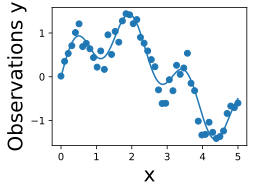

In [2]:
def data_maker1(x, sig):
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(x.shape[0]) * sig

sig = 0.25
train_x, test_x = np.linspace(0, 5, 50), np.linspace(0, 5, 500)
train_y, test_y = data_maker1(train_x, sig=sig), data_maker1(test_x, sig=0.)

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("Observations y", fontsize=20)
d2l.plt.show()

Here we see the noisy observations as circles, and the noise-free function in blue that we wish to find. 

Now, let's specify a GP prior over the latent noise-free function, $f(x)\sim \mathcal{GP}(m,k)$. We'll use a mean function $m(x) = 0$, and an RBF covariance function (kernel)
$$k(x_i,x_j) = a^2\exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right).$$


In [3]:
mean = np.zeros(test_x.shape[0])
cov = d2l.rbfkernel(test_x, test_x, ls=0.2)

We have started with a length-scale of 0.2. Before we fit the data, it is important to consider whether we have specified a reasonable prior. Let's visualize some sample functions from this prior, as well as the 95\% credible set (we believe there's a 95\% chance that the true function is within this region).


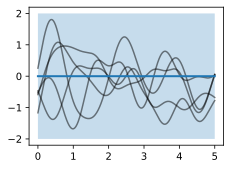

In [4]:
prior_samples = np.random.multivariate_normal(mean=mean, cov=cov, size=5)
d2l.plt.plot(test_x, prior_samples.T, color='black', alpha=0.5)
d2l.plt.plot(test_x, mean, linewidth=2.)
d2l.plt.fill_between(test_x, mean - 2 * np.diag(cov), mean + 2 * np.diag(cov),
                 alpha=0.25)
d2l.plt.show()

Do these samples look reasonable? Are the high-level properties of the functions aligned with the type of data we are trying to model?

Now let's form the mean and variance of the posterior predictive distribution at any arbitrary test point $x_*$.

$$
\bar{f}_{*} = K(x, x_*)^T (K(x, x) + \sigma^2 I)^{-1}y
$$

$$
V(f_{*}) = K(x_*, x_*) - K(x, x_*)^T (K(x, x) + \sigma^2 I)^{-1}K(x, x_*)
$$

Before we make predictions, we should learn our kernel hyperparameters $\theta$ and noise variance $\sigma^2$. Let's initialize our length-scale at 0.75, as our prior functions looked too quickly varying compared to the data we are fitting. We'll also guess a noise standard deviation $\sigma$ of 0.75. 

In order to learn these parameters, we will maximize the marginal likelihood with respect to these parameters.

$$
\log p(y | X) = \log \int p(y | f, X)p(f | X)df
$$
$$
\log p(y | X) = -\frac{1}{2}y^T(K(x, x) + \sigma^2 I)^{-1}y - \frac{1}{2}\log |K(x, x) + \sigma^2 I| - \frac{n}{2}\log 2\pi
$$


Perhaps our prior functions were too quickly varying. Let's guess a length-scale of 0.4. We'll also guess a noise standard deviation of 0.75. These are simply hyperparameter initializations --- we will learn these parameters from the marginal likelihood.


In [5]:
ell_est = 0.4
post_sig_est = 0.5

def neg_MLL(pars):
    K = d2l.rbfkernel(train_x, train_x, ls=pars[0])
    kernel_term = -0.5 * train_y @ \
        np.linalg.inv(K + pars[1] ** 2 * np.eye(train_x.shape[0])) @ train_y
    logdet = -0.5 * np.log(np.linalg.det(K + pars[1] ** 2 * \
                                         np.eye(train_x.shape[0])))
    const = -train_x.shape[0] / 2. * np.log(2 * np.pi)

    return -(kernel_term + logdet + const)


learned_hypers = optimize.minimize(neg_MLL, x0=np.array([ell_est,post_sig_est]),
                                   bounds=((0.01, 10.), (0.01, 10.)))
ell = learned_hypers.x[0]
post_sig_est = learned_hypers.x[1]

In this instance, we learn a length-scale of 0.299, and a noise standard deviation of 0.24. Note that the learned noise is extremely close to the true noise, which helps indicate that our GP is a very well-specified to this problem. 

In general, it is crucial to put careful thought into selecting the kernel and initializing the hyperparameters. While marginal likelihood optimization can be relatively robust to initialization, it is not immune to poor initializations. Try running the above script with a variety of initializations and see what results you find.

Now, let's make predictions with these learned hypers.


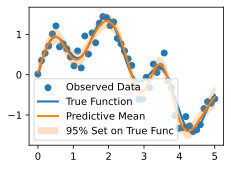

In [6]:
K_x_xstar = d2l.rbfkernel(train_x, test_x, ls=ell)
K_x_x = d2l.rbfkernel(train_x, train_x, ls=ell)
K_xstar_xstar = d2l.rbfkernel(test_x, test_x, ls=ell)

post_mean = K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ train_y
post_cov = K_xstar_xstar - K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ K_x_xstar

lw_bd = post_mean - 2 * np.sqrt(np.diag(post_cov))
up_bd = post_mean + 2 * np.sqrt(np.diag(post_cov))

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
d2l.plt.legend(['Observed Data', 'True Function', 'Predictive Mean', '95% Set on True Func'])
d2l.plt.show()

We see the posterior mean in orange almost perfectly matches the true noise free function! Note that the 95\% credible set we are showing is for the latent _noise free_ (true) function, and not the data points. We see that this credible set entirely contains the true function, and does not seem overly wide or narrow. We would not want nor expect it to contain the data points. If we wish to have a credible set for the observations, we should compute


In [7]:
lw_bd_observed = post_mean - 2 * np.sqrt(np.diag(post_cov) + post_sig_est ** 2)
up_bd_observed = post_mean + 2 * np.sqrt(np.diag(post_cov) + post_sig_est ** 2)

There are two sources of uncertainty, _epistemic_ uncertainty, representing _reducible_ uncertainty, and _aleatoric_ or _irreducible_ uncertainty. The _epistemic_ uncertainty here represents uncertainty about the true values of the noise free function. This uncertainty should grow as we move away from the data points, as away from the data there are a greater variety of function values consistent with our data. As we observe more and more data, our beliefs about the true function become more confident, and the epistemic uncertainty disappears. The _aleatoric_ uncertainty in this instance is the observation noise, since the data are given to us with this noise, and it cannot be reduced.

The _epistemic_ uncertainty in the data is captured by variance of the latent noise free function np.diag(post\_cov). The _aleatoric_ uncertainty is captured by the noise variance post_sig_est**2. 

Unfortunately, people are often careless about how they represent uncertainty, with many papers showing error bars that are completely undefined, no clear sense of whether we are visualizing epistemic or aleatoric uncertainty or both, and confusing noise variances with noise standard deviations, standard deviations with standard errors, confidence intervals with credible sets, and so on. Without being precise about what the uncertainty represents, it is essentially meaningless. 

In the spirit of playing close attention to what our uncertainty represents, it is crucial to note that we are taking _two times_ the _square root_ of our variance estimate for the noise free function. Since our predictive distribution is Gaussian, this quantity enables us to form a 95\% credible set, representing our beliefs about the interval which is 95\% likely to contain the ground truth function. The noise _variance_ is living on a completely different scale, and is much less interpretable. 

Finally, let's take a look at 20 posterior samples. These samples tell us what types of functions we believe might fit our data, a posteriori.


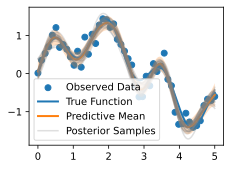

In [8]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.plot(test_x, post_samples.T, color='gray', alpha=0.25)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(['Observed Data', 'True Function', 'Predictive Mean', 'Posterior Samples'])
d2l.plt.show()

In basic regression applications, it is most common to use the posterior predictive mean and standard deviation as a point predictor and metric for uncertainty, respectively. In more advanced applications, such as Bayesian optimization with Monte Carlo acquisition functions, or Gaussian processes for model-based RL, it often necessary to take posterior samples. However, even if not strictly required in the basic applications, these samples give us more intuition about the fit we have for the data, and are often useful to include in visualizations. 

## Making Life Easy with GPyTorch

As we have seen, it is actually pretty easy to implement basic Gaussian process regression entirely from scratch. However, as soon as we want to explore a variety of kernel choices, consider approximate inference (which is needed even for classification), combine GPs with neural networks, or even have a dataset larger than about 10,000 points, then an implementation from scratch becomes unwieldy and cumbersome. Some of the most effective methods for scalable GP inference, such as SKI (also known as KISS-GP), can require hundreds of lines of code implementing advanced numerical linear algebra routines. 

In these cases, the _GPyTorch_ library will make our lives a lot easier. We'll be discussing GPyTorch more in future notebooks on Gaussian process numerics, and advanced methods. The GPyTorch library contains [many examples](https://github.com/cornellius-gp/gpytorch/tree/master/examples). To get a feel for the package, we will walk through the [simple regression example](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb), showing how it can be adapted to reproduce our above results using GPyTorch. This may seem like a lot of code to simply reproduce the basic regression above, and in a sense, it is. But we can immediately use a variety of kernels, scalable inference techniques, and approximate inference, by only changing a few lines of code from below, instead of writing potentially thousands of lines of new code.


In [9]:
# First let's convert our data into tensors for use with PyTorch
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)

# We are using exact GP inference with a zero mean and RBF kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

This code block puts the data in the right format for GPyTorch, and specifies that we are using exact inference, as well
the mean function (zero) and kernel function (RBF) that we want to use. We can use any other kernel very easily, by 
calling, for instance, gpytorch.kernels.matern_kernel(), or gpyotrch.kernels.spectral_mixture_kernel(). So far, we have
only discussed exact inference, where it is possible to infer a predictive distribution without making any approximations.
For Gaussian processes, we can only perform exact inference when we have a Gaussian likelihood; more specifically, when we
assume that our observations are generated as a noise-free function represented by a Gaussian process, plus Gaussian noise.
In future notebooks, we will consider other settings, such as classification, where we cannot make these assumptions.


In [10]:
# Initialize Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer, includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# Set our loss as the negative log GP marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

Here, we explicitly specify the likelihood we want to use (Gaussian), the objective we will use for training kernel hyperparameters (here, the marginal likelihood), and the procedure we we want to use for optimizing that objective (in this case, Adam). We note that while we are using Adam, which is a "stochastic" optimizer, in this case, it is full-batch Adam. Because the marginal likelihood does not factorize over data instances, we cannot use an optimizer over "mini-batches" of data and be guaranteed convergence. Other optimizers, such as L-BFGS, are also supported by GPyTorch. Unlike in standard deep learning, doing a good job of optimizing the marginal likelihood corresponds strongly with good generalization, which often inclines us towards powerful optimizers like L-BFGS, assuming they are not prohibitively expensive.


In [11]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
              f'squared lengthscale: '
              f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
              f'noise variance: {model.likelihood.noise.item():.3f}')
    optimizer.step()

Iter 1/50 - Loss: 0.989 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.698 squared lengthscale: 0.489 noise variance: 0.312
Iter 21/50 - Loss: 0.424 squared lengthscale: 0.486 noise variance: 0.126
Iter 31/50 - Loss: 0.262 squared lengthscale: 0.449 noise variance: 0.053
Iter 41/50 - Loss: 0.259 squared lengthscale: 0.425 noise variance: 0.031


Here we actually run the optimization procedure, outputting the values of the loss every 10 iterations.


In [12]:
# Get into evaluation (predictive posterior) mode
test_x = torch.tensor(test_x)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x))

The above codeblock enables us to make predictions on our test inputs.


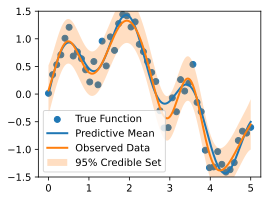

In [13]:
with torch.no_grad():
    # Initialize plot
    f, ax = d2l.plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower bounds for 95\% credible set (in this case, in
    # observation space)
    lower, upper = observed_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy())
    ax.plot(test_x.numpy(), test_y.numpy(), linewidth=2.)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), linewidth=2.)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(['True Function', 'Predictive Mean', 'Observed Data',
               '95% Credible Set'])

Finally, we plot the fit.

We see the fits are virtually identical. A few things to note: GPyTorch is working with _squared_ length-scales and observation noise. For example, our learned noise standard deviation in the for scratch code is about 0.283. The noise variance found by GPyTorch is $0.81 \approx 0.283^2$. In the GPyTorch plot, we also show the credible set in the _observation space_ rather than the latent function space, to demonstrate that they indeed cover the observed datapoints.

## Summary

We can combine a Gaussian process prior with data to form a posterior, which we use to make predictions. We can also form a marginal likelihood, which is useful for automatic learning of kernel hyperparameters, which control properties such as the rate of variation of the Gaussian process. The mechanics of forming the posterior and learning kernel hyperparameters for regression are simple, involving about a dozen lines of code. This notebook is a good reference for any reader wanting to quickly get "up and running" with Gaussian processes. We also introduced the GPyTorch library. Although the GPyTorch code for basic regression is relatively long, it can be trivially modified for other kernel functions, or more advanced functionality we will discuss in future notebooks, such as scalable inference, or non-Gaussian likelihoods for classification.


## Exercises

1. We have emphasized the importance of _learning_ kernel hyperparameters, and the effect of hyperparameters and kernels on the generalization properties of Gaussian processes. Try skipping the step where we learn hypers, and instead guess a variety of length-scales and noise variances, and check their effect on predictions. What happens when you use a large length-scale? A small length-scale? A large noise variance? A small noise variance?
2. We have said that the marginal likelihood is not a convex objective, but that hyperparameters like length-scale and noise variance can be reliably estimated in GP regression. This is generally true --- in fact, the marginal likelihood is _much_ better at learning length-scale hyperparameters than conventional approaches in spatial statistics, which involve fitting empirical autocorrelation functions ("covariograms"). Arguably, the biggest contribution from machine learning to Gaussian process research, at least before recent work on scalable inference, was the introduction of the marginal lkelihood for hyperparameter learning. 

*However*, different pairings of even these parameters provide interpretably different plausible explanations for many datasets, leading to local optima in our objective. If we use a large length-scale, then we assume the true underlying function is slowly varying. If the observed data _are_ varying significantly, then the only we can plausibly have a large length-scale is with a large noise-variance. If we use a small length-scale, on the  other hand, our fit will be very sensitive to the variations in the data, leaving little room to explain variations with noise (aleatoric uncertainty). 

Try seeing if you can find these local optima: initialize with very large length-scale with large noise, and small length-scales with small noise. Do you converge to different solutions?
  
3. We have said that a fundamental advantage of Bayesian methods is in naturally representing _epistemic_ uncertainty. In the above example, we cannot fully see the effects of epistemic uncertainty. Try instead to predict with `test_x = np.linspace(0, 10, 1000)`. What happens to the 95\% credible set as your predictions move beyond the data? Does it cover the true function in that interval? What happens if you only visualize aleatoric uncertainty in that region? 

4. Try running the above example, but instead with 10,000, 20,000 and 40,000 training points, and measure the runtimes. How does the training time scale? Alternatively, how do the runtimes scale with the number of test points? Is it different for the predictive mean and the predictive variance? Answer this question both by theoretically working out the training and testing time complexities, and by running the code above with a different number of points.

5. Try running the GPyTorch example with different covariance functions, such as the Matern kernel. How do the results change? How about the spectral mixture kernel, found in the GPyTorch library? Are some easier to train the marginal likelihood than others? Are some more valuable for long-range versus short-range predictions?

6. In our GPyTorch example, we plotted the predictive distribution including observation noise, while in our "from scratch" example, we only included epistemic uncertainty. Re-do the GPyTorch example, but this time only plotting epistemic uncertainty, and compare to the from-scratch results. Do the predictive distributions now look the same?  (They should.)


[Discussions](https://discuss.d2l.ai/t/12117)
